In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

print("Num GPU Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPU Available:  2
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:41:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5



2022-05-04 14:11:14.044602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9644 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:41:00.0, compute capability: 7.5
2022-05-04 14:11:14.046037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9644 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5


# Evalutaion Stuff

## Function to aggregate windowed predictions

In [127]:
def get_max_preds(preds, window_size=15):
    '''
    Aggregates every window_size predictions by summing probabilites of each
    Returns the class/index with the highest summed prediction
    '''
    final_preds = []
    for i in range(len(preds)//window_size):
        aggregated_preds = []
        for j in range(window_size):
            idx = i*window_size+j                                 # get indices for windows within whole record
            aggregated_preds.append(preds[idx])                   # append windows to list
        summed_preds = np.sum(np.array(aggregated_preds), axis=0) # sum aggregated predicions
        final_preds.append(np.argmax(summed_preds))               # get index of highest prediction and append to list
    return final_preds

In [93]:
# def get_max_preds(preds):
#     '''
#     Aggregates window level predictions by taking class that is predicted (highest probability) the most often
#     '''
#     final_preds = []
#     for i in range(len(preds)//15):
#         record_preds = []
#         for j in range(15):
#             idx = i*15+j
#             record_preds.append(np.argmax(preds[idx]))
#         pred = np.argmax(np.bincount(record_preds))
#         final_preds.append(pred)
#     return final_preds

## Read true labels for predictions

In [3]:
path = '/project/GutIntelligenceLab/bwl3xy/ecg'
os.chdir(path)

In [15]:
# Get true labels
database = pd.read_pickle('data/database.pkl')
Y = np.array(database['class'])
test_fold = [10] 
test_idx = np.where(np.isin(database['strat_fold'], test_fold))
y_true  = list(Y[test_idx])

In [83]:
## NOTE: SEHYP (20) removed from labels as there are no records of this class in the validation set

label_map = {'NORM': 0,
             'IMI': 1,
             'STTC': 2,
             'NST_': 3,
             'LVH': 4,
             'LAFB/LPFB': 5,
             'IRBBB': 6,
             'IVCD': 7,
             'AMI': 8,
             '_AVB': 9,
             'ISCA': 10,
             'ISCI': 11,
             'CRBBB': 12,
             'CLBBB': 13,
             'RAO/RAE': 14,
             'RVH': 15,
             'ISC_': 16,
             'ILBBB': 17,
             'WPW': 18,
             'LAO/LAE': 19,
#              'SEHYP': 20,
             'LMI': 21,
             'PMI': 22}

label_list = list(label_map.keys())

# Read in data from TFRecords

In [4]:
def parse_ecg_tensor_from_TFR(TFRecord):
    dataset = (tf.data.TFRecordDataset(TFRecord).map(lambda x: tf.io.parse_tensor(x, tf.double)))
    dataset = dataset.map(lambda x: tf.reshape(x, [12,250]))
    return dataset

def parse_label_from_TFR(TFRecord):
    dataset = (tf.data.TFRecordDataset(TFRecord).map(lambda x: tf.io.parse_tensor(x, tf.int64)))
    dataset = dataset.map(lambda x: tf.reshape(x, []))
    return dataset

In [6]:
X_train_ds = parse_ecg_tensor_from_TFR('data/X_train.tfrecord')
X_val_ds = parse_ecg_tensor_from_TFR('data/X_val.tfrecord')
X_test_ds = parse_ecg_tensor_from_TFR('data/X_test.tfrecord')
Y_train_ds = parse_label_from_TFR('data/Y_train.tfrecord')
Y_val_ds = parse_label_from_TFR('data/Y_val.tfrecord')
Y_test_ds = parse_label_from_TFR('data/Y_test.tfrecord')

In [22]:
BATCH_SIZE = 256

train_ds = tf.data.Dataset.zip((X_train_ds, Y_train_ds)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.zip((X_val_ds, Y_val_ds)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.zip((X_test_ds, Y_test_ds)).batch(1)

In [8]:
num_classes = 23
input_shape = (12,250)

# Model 1: 1D Basic CNN

In [19]:
model = keras.models.Sequential([
    
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.GlobalAveragePooling1D(),

    keras.layers.Dense(num_classes, activation="softmax")
])

model.build(input_shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 12, 64)            48064     
                                                                 
 batch_normalization_6 (Batc  (None, 12, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 12, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 12, 64)            12352     
                                                                 
 batch_normalization_7 (Batc  (None, 12, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 12, 64)           

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
epochs = 30
model_output = 'models/basic_cnn.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
#              keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15


2022-05-04 14:07:58.092863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


868/868 [==============================] - 20s 15ms/step - loss: 1.8556 - accuracy: 0.4729 - val_loss: 1.7479 - val_accuracy: 0.4978
Epoch 2/15
868/868 [==============================] - 12s 14ms/step - loss: 1.6267 - accuracy: 0.5201 - val_loss: 1.6434 - val_accuracy: 0.5193
Epoch 3/15
868/868 [==============================] - 12s 14ms/step - loss: 1.5412 - accuracy: 0.5409 - val_loss: 1.5872 - val_accuracy: 0.5314
Epoch 4/15
868/868 [==============================] - 12s 14ms/step - loss: 1.4782 - accuracy: 0.5579 - val_loss: 1.5534 - val_accuracy: 0.5411
Epoch 5/15
868/868 [==============================] - 12s 14ms/step - loss: 1.4278 - accuracy: 0.5716 - val_loss: 1.5294 - val_accuracy: 0.5471
Epoch 6/15
868/868 [==============================] - 12s 14ms/step - loss: 1.3875 - accuracy: 0.5825 - val_loss: 1.5019 - val_accuracy: 0.5541
Epoch 7/15
868/868 [==============================] - 12s 14ms/step - loss: 1.3557 - accuracy: 0.5910 - val_loss: 1.4889 - val_accuracy: 0.5577
Epo

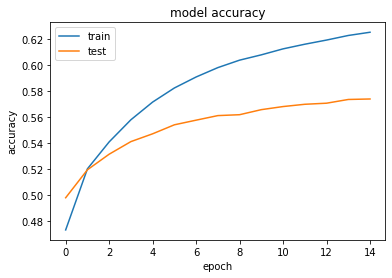

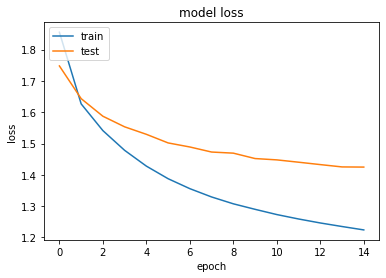

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [155]:
# model = tf.keras.models.load_model('models/basic_cnn.h5')
model.evaluate(test_ds)

In [156]:
preds = model.predict(test_ds)

In [157]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.5944808231992517

In [158]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.703     0.936     0.803       921
         IMI      0.380     0.420     0.399       207
        STTC      0.378     0.541     0.445       181
        NST_      0.000     0.000     0.000        46
         LVH      0.430     0.490     0.458       100
   LAFB/LPFB      0.619     0.148     0.239        88
       IRBBB      0.417     0.160     0.231        94
        IVCD      0.000     0.000     0.000        36
         AMI      0.586     0.337     0.428       193
        _AVB      0.000     0.000     0.000        23
        ISCA      0.246     0.237     0.241        59
        ISCI      0.000     0.000     0.000        18
       CRBBB      0.744     0.674     0.707        43
       CLBBB      0.867     0.736     0.796        53
     RAO/RAE      0.000     0.000     0.000         4
         RVH      0.000     0.000     0.000         3
        ISC_      0.000     0.000     0.000        47
       ILBBB      0.000    

# Model 2: 1D Resnet
adapted from: https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/resnet.py

when tuning start with learning rate->mini_batch_size -> momentum-> #hidden_units -> # learning_rate_decay -> #layers 

In [137]:
def resnet1d(input_shape, nb_classes, dropout_rate=0.25, learning_rate=0.0001):
    
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1
    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)
    
    output_block_1 = tf.keras.layers.Dropout(rate=dropout_rate)(output_block_1)

    
    # BLOCK 2
    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)
    
    output_block_2 = tf.keras.layers.Dropout(rate=dropout_rate)(output_block_2)

    
    # BLOCK 3
    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)
    
    output_block_3 = tf.keras.layers.Dropout(rate=dropout_rate)(output_block_3)

    
    # FINAL
    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
    
    # insert droupout layer

    output_layer = tf.keras.layers.Dropout(rate=dropout_rate)(gap_layer)
    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(output_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=opt)


    return model

In [138]:
learning_rate = 0.001
dropout_rate = 0.25

resnet_model = resnet1d(input_shape = input_shape,
                         nb_classes = num_classes,
                         learning_rate=learning_rate)

resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12, 250)]    0           []                               
                                                                                                  
 conv1d_37 (Conv1D)             (None, 12, 64)       128064      ['input_4[0][0]']                
                                                                                                  
 batch_normalization_33 (BatchN  (None, 12, 64)      256         ['conv1d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_18 (Activation)     (None, 12, 64)       0           ['batch_normalization_33[0]

In [139]:
epochs = 50
model_output = 'models/resnet.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
#              keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),]

history = resnet_model.fit(train_ds,
                           validation_data=val_ds,
                           epochs=epochs,
                           callbacks=callbacks,
                           verbose=1)

Epoch 1/50
868/868 [==============================] - 22s 23ms/step - loss: 1.9008 - accuracy: 0.4661 - val_loss: 1.7077 - val_accuracy: 0.5007
Epoch 2/50
868/868 [==============================] - 19s 22ms/step - loss: 1.6343 - accuracy: 0.5157 - val_loss: 1.5966 - val_accuracy: 0.5283
Epoch 3/50
868/868 [==============================] - 19s 22ms/step - loss: 1.5317 - accuracy: 0.5412 - val_loss: 1.5652 - val_accuracy: 0.5338
Epoch 4/50
868/868 [==============================] - 19s 22ms/step - loss: 1.4640 - accuracy: 0.5595 - val_loss: 1.5417 - val_accuracy: 0.5305
Epoch 5/50
868/868 [==============================] - 19s 22ms/step - loss: 1.4110 - accuracy: 0.5740 - val_loss: 1.5432 - val_accuracy: 0.5283
Epoch 6/50
868/868 [==============================] - 19s 22ms/step - loss: 1.3645 - accuracy: 0.5866 - val_loss: 1.4949 - val_accuracy: 0.5439
Epoch 7/50
868/868 [==============================] - 19s 22ms/step - loss: 1.3229 - accuracy: 0.5989 - val_loss: 1.4861 - val_accuracy:

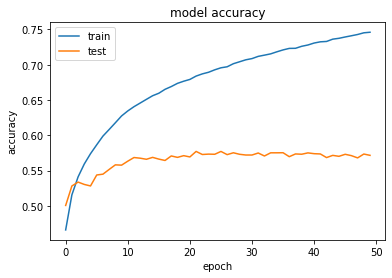

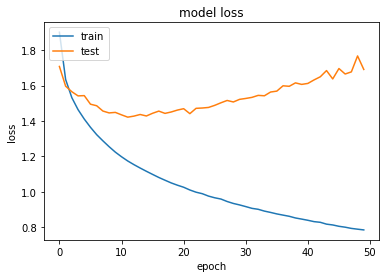

In [140]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [141]:
# resnet_model = tf.keras.models.load_model('models/resnet.h5')
resnet_model.evaluate(test_ds)

32070/32070 [==============================] - 94s 3ms/step - loss: 1.7764 - accuracy: 0.5618


[1.7764487266540527, 0.5617711544036865]

In [142]:
preds = resnet_model.predict(test_ds)

In [143]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6122544434050514

In [144]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.706     0.964     0.815       921
         IMI      0.431     0.391     0.410       207
        STTC      0.463     0.376     0.415       181
        NST_      0.000     0.000     0.000        46
         LVH      0.353     0.540     0.427       100
   LAFB/LPFB      0.534     0.443     0.484        88
       IRBBB      0.457     0.223     0.300        94
        IVCD      0.000     0.000     0.000        36
         AMI      0.591     0.404     0.480       193
        _AVB      0.000     0.000     0.000        23
        ISCA      0.304     0.288     0.296        59
        ISCI      0.000     0.000     0.000        18
       CRBBB      0.536     0.349     0.423        43
       CLBBB      0.904     0.887     0.895        53
     RAO/RAE      0.000     0.000     0.000         4
         RVH      0.000     0.000     0.000         3
        ISC_      0.000     0.000     0.000        47
       ILBBB      0.000    

# Model 3: 1D Inception

In [36]:
def inception1d(input_shape, nb_classes):

    input_layer = keras.layers.Input(input_shape)

    tower_1 = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(input_layer)

    tower_2 = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(input_layer)
    tower_2 = keras.layers.Conv1D(128, 3, padding='same', activation='relu')(tower_2)

    tower_3 = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(input_layer)
    tower_3 = keras.layers.Conv1D(32, 5, padding='same', activation='relu')(tower_3)

    pool = keras.layers.MaxPooling1D(3, strides=1, padding='same')(input_layer)
    pool = keras.layers.Conv1D(32, 1, padding='same', activation='relu')(pool)


    output = keras.layers.concatenate([tower_1, tower_2, tower_3, pool], axis = -1)

    output = keras.layers.Flatten()(output)
    out = keras.layers.Dense(nb_classes, activation='softmax')(output)

    model = keras.models.Model(inputs = input_layer, outputs = out)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [37]:
inception_model = inception1d(input_shape = input_shape, 
                              nb_classes = num_classes)
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 250)]    0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 12, 64)       16064       ['input_1[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 12, 64)       16064       ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 12, 250)      0           ['input_1[0][0]']                
                                                                                              

In [38]:
epochs = 25
model_output = 'models/inception.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),]

history = inception_model.fit(train_ds,
                             validation_data=val_ds,
                             epochs=epochs,
                             callbacks=callbacks,
                             verbose=1)

Epoch 1/25
868/868 [==============================] - 13s 14ms/step - loss: 1.7541 - accuracy: 0.5060 - val_loss: 1.6463 - val_accuracy: 0.5176 - lr: 0.0010
Epoch 2/25
868/868 [==============================] - 12s 14ms/step - loss: 1.4365 - accuracy: 0.5679 - val_loss: 1.4863 - val_accuracy: 0.5527 - lr: 0.0010
Epoch 3/25
868/868 [==============================] - 12s 14ms/step - loss: 1.3318 - accuracy: 0.5925 - val_loss: 1.4369 - val_accuracy: 0.5662 - lr: 0.0010
Epoch 4/25
868/868 [==============================] - 12s 14ms/step - loss: 1.2671 - accuracy: 0.6084 - val_loss: 1.5293 - val_accuracy: 0.5574 - lr: 0.0010
Epoch 5/25
868/868 [==============================] - 12s 14ms/step - loss: 1.2166 - accuracy: 0.6221 - val_loss: 1.4087 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 6/25
868/868 [==============================] - 12s 14ms/step - loss: 1.1578 - accuracy: 0.6356 - val_loss: 1.4047 - val_accuracy: 0.5823 - lr: 0.0010
Epoch 7/25
868/868 [==============================] - 12s 

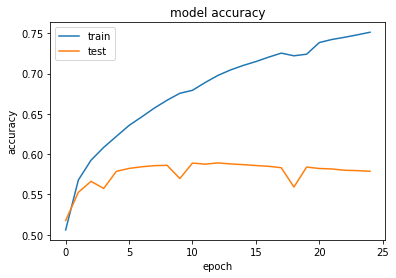

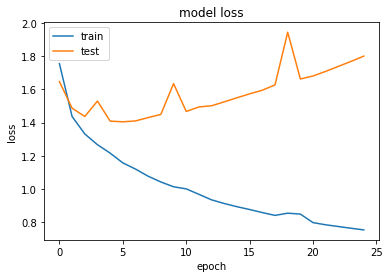

In [39]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# inception_model = tf.keras.models.load_model('models/inception.h5')
inception_model.evaluate(test_ds)

32070/32070 [==============================] - 52s 2ms/step - loss: 1.9308 - accuracy: 0.5702


[1.9307893514633179, 0.5701590180397034]

In [128]:
preds = inception_model.predict(test_ds)

In [129]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6239476145930777

In [126]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6239476145930777

In [130]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.700     0.977     0.816       921
         IMI      0.539     0.232     0.324       207
        STTC      0.388     0.558     0.458       181
        NST_      0.000     0.000     0.000        46
         LVH      0.472     0.420     0.444       100
   LAFB/LPFB      0.519     0.477     0.497        88
       IRBBB      0.536     0.160     0.246        94
        IVCD      0.000     0.000     0.000        36
         AMI      0.570     0.508     0.537       193
        _AVB      0.000     0.000     0.000        23
        ISCA      0.423     0.186     0.259        59
        ISCI      0.500     0.056     0.100        18
       CRBBB      0.707     0.674     0.690        43
       CLBBB      0.887     0.887     0.887        53
     RAO/RAE      0.000     0.000     0.000         4
         RVH      0.000     0.000     0.000         3
        ISC_      0.000     0.000     0.000        47
       ILBBB      0.000    

optimize model for **precision** when you want to **decrease the number of false positives**.

optimize model for **recall** if you want to **decrease the number of false negatives**.

# Model 4: LSTM

In [35]:
learning_rate = 0.0001
dropout_rate = 0.25

lstm_model = keras.models.Sequential([
    
    keras.layers.LSTM(units=128, return_sequences=True, input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=dropout_rate),
    
    keras.layers.LSTM(units=64, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=dropout_rate),
    
    keras.layers.LSTM(units=32, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=dropout_rate),
    
    keras.layers.Dense(128),
    keras.layers.Activation('relu'),
    
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(rate=dropout_rate),
    
    keras.layers.Dense(num_classes, activation='softmax')
])


opt = keras.optimizers.Adam(learning_rate=learning_rate)

lstm_model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=opt)

lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 12, 128)           194048    
                                                                 
 batch_normalization_10 (Bat  (None, 12, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 12, 128)           0         
                                                                 
 lstm_28 (LSTM)              (None, 12, 64)            49408     
                                                                 
 batch_normalization_11 (Bat  (None, 12, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 12, 64)          

In [36]:
epochs = 100
model_output = 'models/lstm.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),]

history = lstm_model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=epochs,
                         callbacks=callbacks,
                         verbose=1)

Epoch 1/50
868/868 [==============================] - 20s 19ms/step - loss: 2.3458 - accuracy: 0.3504 - val_loss: 1.9766 - val_accuracy: 0.4458
Epoch 2/50
868/868 [==============================] - 16s 19ms/step - loss: 1.9418 - accuracy: 0.4537 - val_loss: 1.8518 - val_accuracy: 0.4649
Epoch 3/50
868/868 [==============================] - 16s 18ms/step - loss: 1.8578 - accuracy: 0.4661 - val_loss: 1.7951 - val_accuracy: 0.4747
Epoch 4/50
868/868 [==============================] - 16s 18ms/step - loss: 1.8042 - accuracy: 0.4777 - val_loss: 1.7560 - val_accuracy: 0.4803
Epoch 5/50
868/868 [==============================] - 16s 18ms/step - loss: 1.7631 - accuracy: 0.4852 - val_loss: 1.7230 - val_accuracy: 0.4880
Epoch 6/50
868/868 [==============================] - 16s 18ms/step - loss: 1.7261 - accuracy: 0.4936 - val_loss: 1.6939 - val_accuracy: 0.4923
Epoch 7/50
868/868 [==============================] - 16s 18ms/step - loss: 1.6971 - accuracy: 0.5008 - val_loss: 1.6750 - val_accuracy:

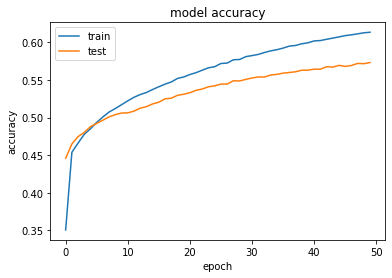

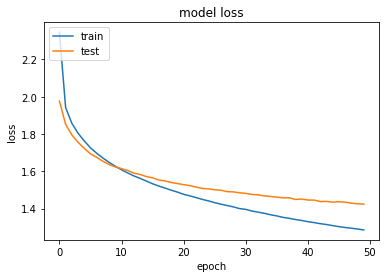

In [37]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# lstm_model = tf.keras.models.load_model('models/lstm.h5')
lstm_model.evaluate(test_ds)

32070/32070 [==============================] - 52s 2ms/step - loss: 1.9308 - accuracy: 0.5702


[1.9307893514633179, 0.5701590180397034]

In [128]:
preds = lstm_model.predict(test_ds)

In [129]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6239476145930777

In [126]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6239476145930777

In [130]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.700     0.977     0.816       921
         IMI      0.539     0.232     0.324       207
        STTC      0.388     0.558     0.458       181
        NST_      0.000     0.000     0.000        46
         LVH      0.472     0.420     0.444       100
   LAFB/LPFB      0.519     0.477     0.497        88
       IRBBB      0.536     0.160     0.246        94
        IVCD      0.000     0.000     0.000        36
         AMI      0.570     0.508     0.537       193
        _AVB      0.000     0.000     0.000        23
        ISCA      0.423     0.186     0.259        59
        ISCI      0.500     0.056     0.100        18
       CRBBB      0.707     0.674     0.690        43
       CLBBB      0.887     0.887     0.887        53
     RAO/RAE      0.000     0.000     0.000         4
         RVH      0.000     0.000     0.000         3
        ISC_      0.000     0.000     0.000        47
       ILBBB      0.000    

# Model 5: Ensemble

In [145]:
resnet_model = tf.keras.models.load_model('models/resnet.h5')
inception_model = tf.keras.models.load_model('models/inception.h5')
lstm_model = tf.keras.models.load_model('models/lstm.h5')

In [150]:
models = [resnet_model, inception_model,lstm_model]
model_input = tf.keras.Input(shape=input_shape)
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

opt = keras.optimizers.Adam(learning_rate=learning_rate)

ensemble_model.compile(loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'],
                          optimizer=opt)

ensemble_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 12, 250)]    0           []                               
                                                                                                  
 model_3 (Functional)           (None, 23)           652951      ['input_7[0][0]']                
                                                                                                  
 model (Functional)             (None, 23)           161879      ['input_7[0][0]']                
                                                                                                  
 sequential_11 (Sequential)     (None, 23)           263959      ['input_7[0][0]']                
                                                                                            

In [151]:
ensemble_model.evaluate(test_ds)

32070/32070 [==============================] - 167s 5ms/step - loss: 1.3145 - accuracy: 0.5991


[1.314463496208191, 0.5990645289421082]

In [152]:
preds = resnet_model.predict(test_ds)

In [153]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.5916744621141253

In [154]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.706     0.946     0.809       921
         IMI      0.329     0.464     0.385       207
        STTC      0.385     0.343     0.363       181
        NST_      0.000     0.000     0.000        46
         LVH      0.346     0.560     0.427       100
   LAFB/LPFB      0.528     0.318     0.397        88
       IRBBB      0.524     0.117     0.191        94
        IVCD      0.000     0.000     0.000        36
         AMI      0.785     0.264     0.395       193
        _AVB      0.000     0.000     0.000        23
        ISCA      0.268     0.186     0.220        59
        ISCI      0.000     0.000     0.000        18
       CRBBB      0.593     0.744     0.660        43
       CLBBB      0.902     0.868     0.885        53
     RAO/RAE      0.000     0.000     0.000         4
         RVH      0.000     0.000     0.000         3
        ISC_      0.000     0.000     0.000        47
       ILBBB      0.000    